In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample
from collections import Counter

In [ ]:
df = pd.read_csv("../data/breast_cancer_final.csv")
df['diagnosis'] = df['diagnosis'].map({'B': 0, 'M': 1})
X = df.drop(columns=["diagnosis"])
y = df["diagnosis"]


Baseline Performance: AUC = 0.9965 ± 0.0049

Class distribution after Oversampling: Counter({np.int64(0): 246, np.int64(1): 246})


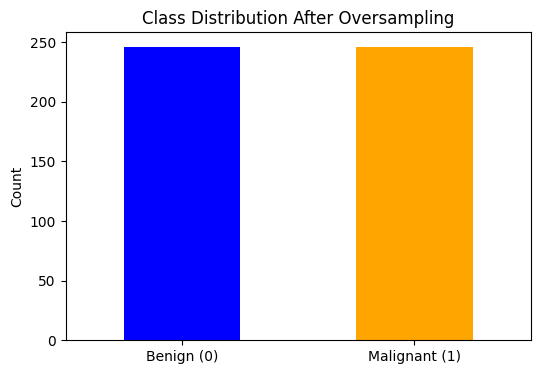

Oversampling Performance: AUC = 0.9996 ± 0.0005

Class distribution after Undersampling: Counter({np.int64(0): 138, np.int64(1): 138})


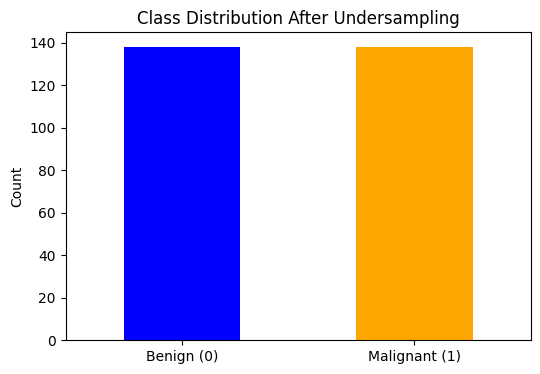

Undersampling Performance: AUC = 0.9941 ± 0.0081

Performance Comparison:


,Method,AUC Mean,AUC Std,Class Ratio
1,Oversampling,0.999584,0.000456,246:246
0,Baseline,0.996464,0.004878,246:138
2,Undersampling,0.994076,0.008120,138:138


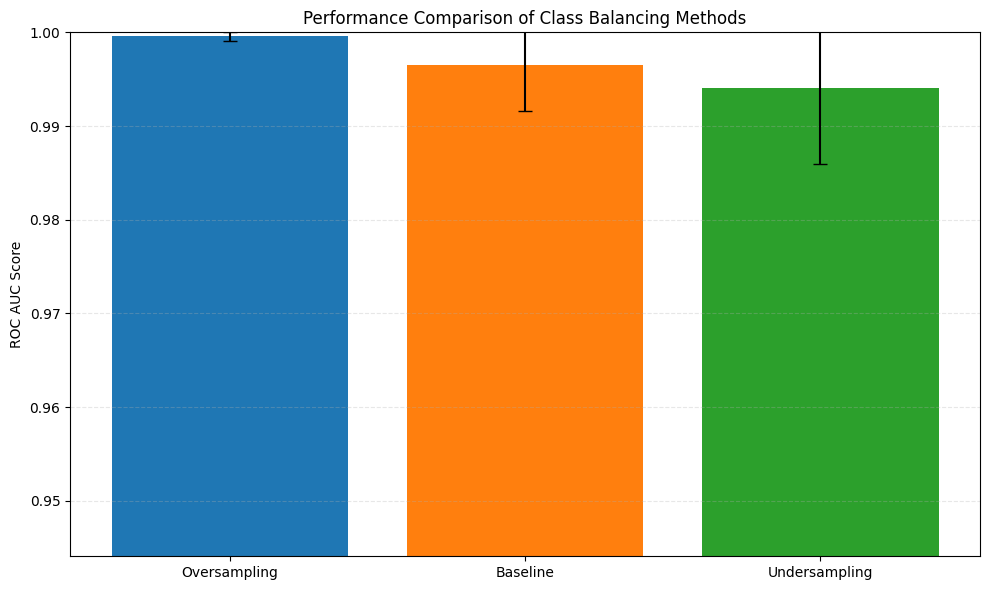

In [9]:
# Initialize Logistic Regression model
lr = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    max_iter=10000,
    C=1.0,
    l1_ratio=0.0,
    random_state=42
)

# Evaluation function
def evaluate_model(X, y, model, cv=5):
    scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')
    return np.mean(scores), np.std(scores)

# Baseline evaluation
baseline_auc, baseline_std = evaluate_model(X, y, lr)
print(f"\nBaseline Performance: AUC = {baseline_auc:.4f} ± {baseline_std:.4f}")

# Separate majority and minority classes
X_majority = X[y == 0]
X_minority = X[y == 1]
y_majority = y[y == 0]
y_minority = y[y == 1]

## Method 1: Manual Oversampling
X_minority_upsampled = resample(X_minority,
                               replace=True,
                               n_samples=len(X_majority),
                               random_state=42)
y_minority_upsampled = np.array([1] * len(X_majority))

X_oversampled = pd.concat([X_majority, X_minority_upsampled])
y_oversampled = np.concatenate([y_majority, y_minority_upsampled])

print("\nClass distribution after Oversampling:", Counter(y_oversampled))
plt.figure(figsize=(6, 4))
pd.Series(y_oversampled).value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title("Class Distribution After Oversampling")
plt.xticks([0, 1], ['Benign (0)', 'Malignant (1)'], rotation=0)
plt.ylabel("Count")
plt.show()

oversample_auc, oversample_std = evaluate_model(X_oversampled, y_oversampled, lr)
print(f"Oversampling Performance: AUC = {oversample_auc:.4f} ± {oversample_std:.4f}")

## Method 2: Manual Undersampling
X_majority_downsampled = resample(X_majority,
                                replace=False,
                                n_samples=len(X_minority),
                                random_state=42)
y_majority_downsampled = np.array([0] * len(X_minority))

X_undersampled = pd.concat([X_majority_downsampled, X_minority])
y_undersampled = np.concatenate([y_majority_downsampled, y_minority])

print("\nClass distribution after Undersampling:", Counter(y_undersampled))
plt.figure(figsize=(6, 4))
pd.Series(y_undersampled).value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title("Class Distribution After Undersampling")
plt.xticks([0, 1], ['Benign (0)', 'Malignant (1)'], rotation=0)
plt.ylabel("Count")
plt.show()

undersample_auc, undersample_std = evaluate_model(X_undersampled, y_undersampled, lr)
print(f"Undersampling Performance: AUC = {undersample_auc:.4f} ± {undersample_std:.4f}")

# Results comparison
results = [
    {"Method": "Baseline", 
     "AUC Mean": baseline_auc, 
     "AUC Std": baseline_std,
     "Class Ratio": f"{Counter(y)[0]}:{Counter(y)[1]}"},
    
    {"Method": "Oversampling", 
     "AUC Mean": oversample_auc, 
     "AUC Std": oversample_std,
     "Class Ratio": f"{len(y_majority)}:{len(y_majority)}"},
     
    {"Method": "Undersampling", 
     "AUC Mean": undersample_auc, 
     "AUC Std": undersample_std,
     "Class Ratio": f"{len(y_minority)}:{len(y_minority)}"}
]

results_df = pd.DataFrame(results).sort_values("AUC Mean", ascending=False)
print("\nPerformance Comparison:")
display(results_df)

# Visualization
plt.figure(figsize=(10, 6))
x_pos = np.arange(len(results_df))
plt.bar(x_pos, results_df['AUC Mean'], yerr=results_df['AUC Std'], 
        capsize=5, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.xticks(x_pos, results_df['Method'])
plt.ylabel("ROC AUC Score")
plt.title("Performance Comparison of Class Balancing Methods")
plt.ylim(min(results_df['AUC Mean']) - 0.05, 1.0)
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()